In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

gpu = True
if gpu:
    import sigkernel as ksig
else:
    import sigkernel_cpu as ksig

# Setup parameters and kernel choice

In [2]:
num_permutations = 10000
n_levels = 4
n_samples = 50
sample_len = 124
difference = True
n_filter_samples = 20
use_log = True
spx_only = True

static_kernel = ksig.static.kernels.LinearKernel()
# static_kernel = ksig.static.kernels.RBFKernel(lengthscale=2.0)
# static_kernel = ksig.static.kernels.PolynomialKernel(degree=1)

# Load Data

In [3]:
def plot_spx_vix(df):
    _, ax = plt.subplots(figsize=(16,9))
    df[['SPX']].plot(ax=ax, label='SPX')
    ax2 = df[['VIX']].plot(ax=ax, label='VIX', secondary_y=True, alpha=0.5)
    ax.legend(labels=['SPX'], loc='upper left')
    ax2.legend(labels=['VIX'], loc='upper right')

def generate_samples(data, n_samples, sample_len, shuffle=True):
    if data.ndim == 2:
        if len(data) < n_samples*sample_len:
            raise ValueError("data length is less than n_samples*sample_len")
    elif data.ndim == 3:
        if data.shape[1] < n_samples*sample_len:
            raise ValueError("data length is less than n_samples*sample_len")

    samples = []
    for i in range(n_samples):
        start = i*sample_len
        end = start + sample_len
        if data.ndim == 2:
            sample = data[start:end]
        elif data.ndim == 3:
            sample = data[:,start:end]
        samples.append(sample)
    if data.ndim == 2:
        samples = np.array(samples)
    elif data.ndim == 3:
        samples = np.stack(samples, axis=1)

    if shuffle:
        np.random.shuffle(samples)

    print(f'Generated {n_samples} samples of length {sample_len} with remaining length {len(data) - n_samples*sample_len} unused')
    return samples

Generated 50 samples of length 124 with remaining length 15 unused


(50, 124, 2)

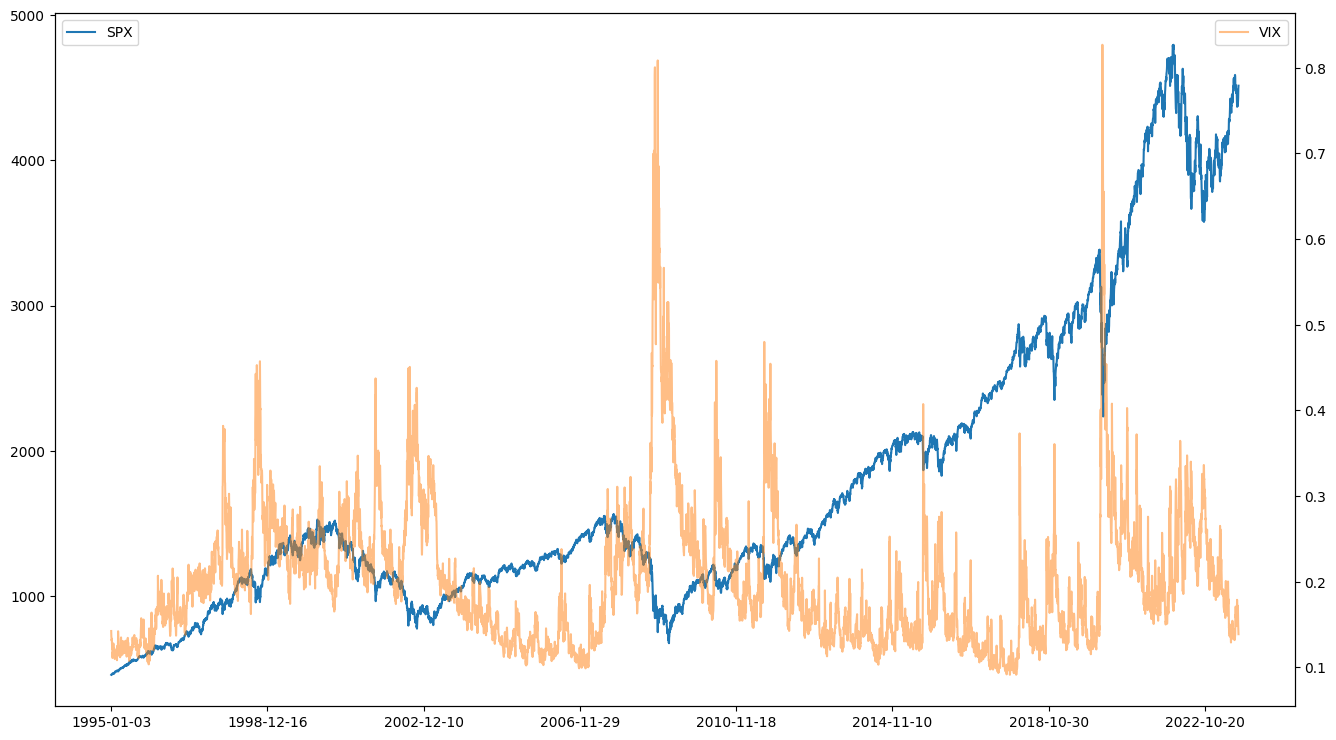

In [4]:
X = pd.read_csv('data/spx_vix_df.csv', index_col=0)
plot_spx_vix(X)
X = X['1998-12-17':].values
X = generate_samples(X, n_samples, sample_len, shuffle=False)
X.shape

In [5]:
samples = np.load('./data/sim_samples_v1.npy')
Y = generate_samples(samples, n_samples, sample_len, shuffle=False)
Y.shape

Generated 50 samples of length 124 with remaining length -6100 unused


(100, 50, 124, 2)

In [6]:
if use_log:
    X = np.log(X)
    Y = np.log(Y)

if spx_only:
    X = X[:,:,:1]
    Y = Y[:,:,:,:1]

X.shape, Y.shape

((50, 124, 1), (100, 50, 124, 1))

# MMD Filter

### Permutation Test

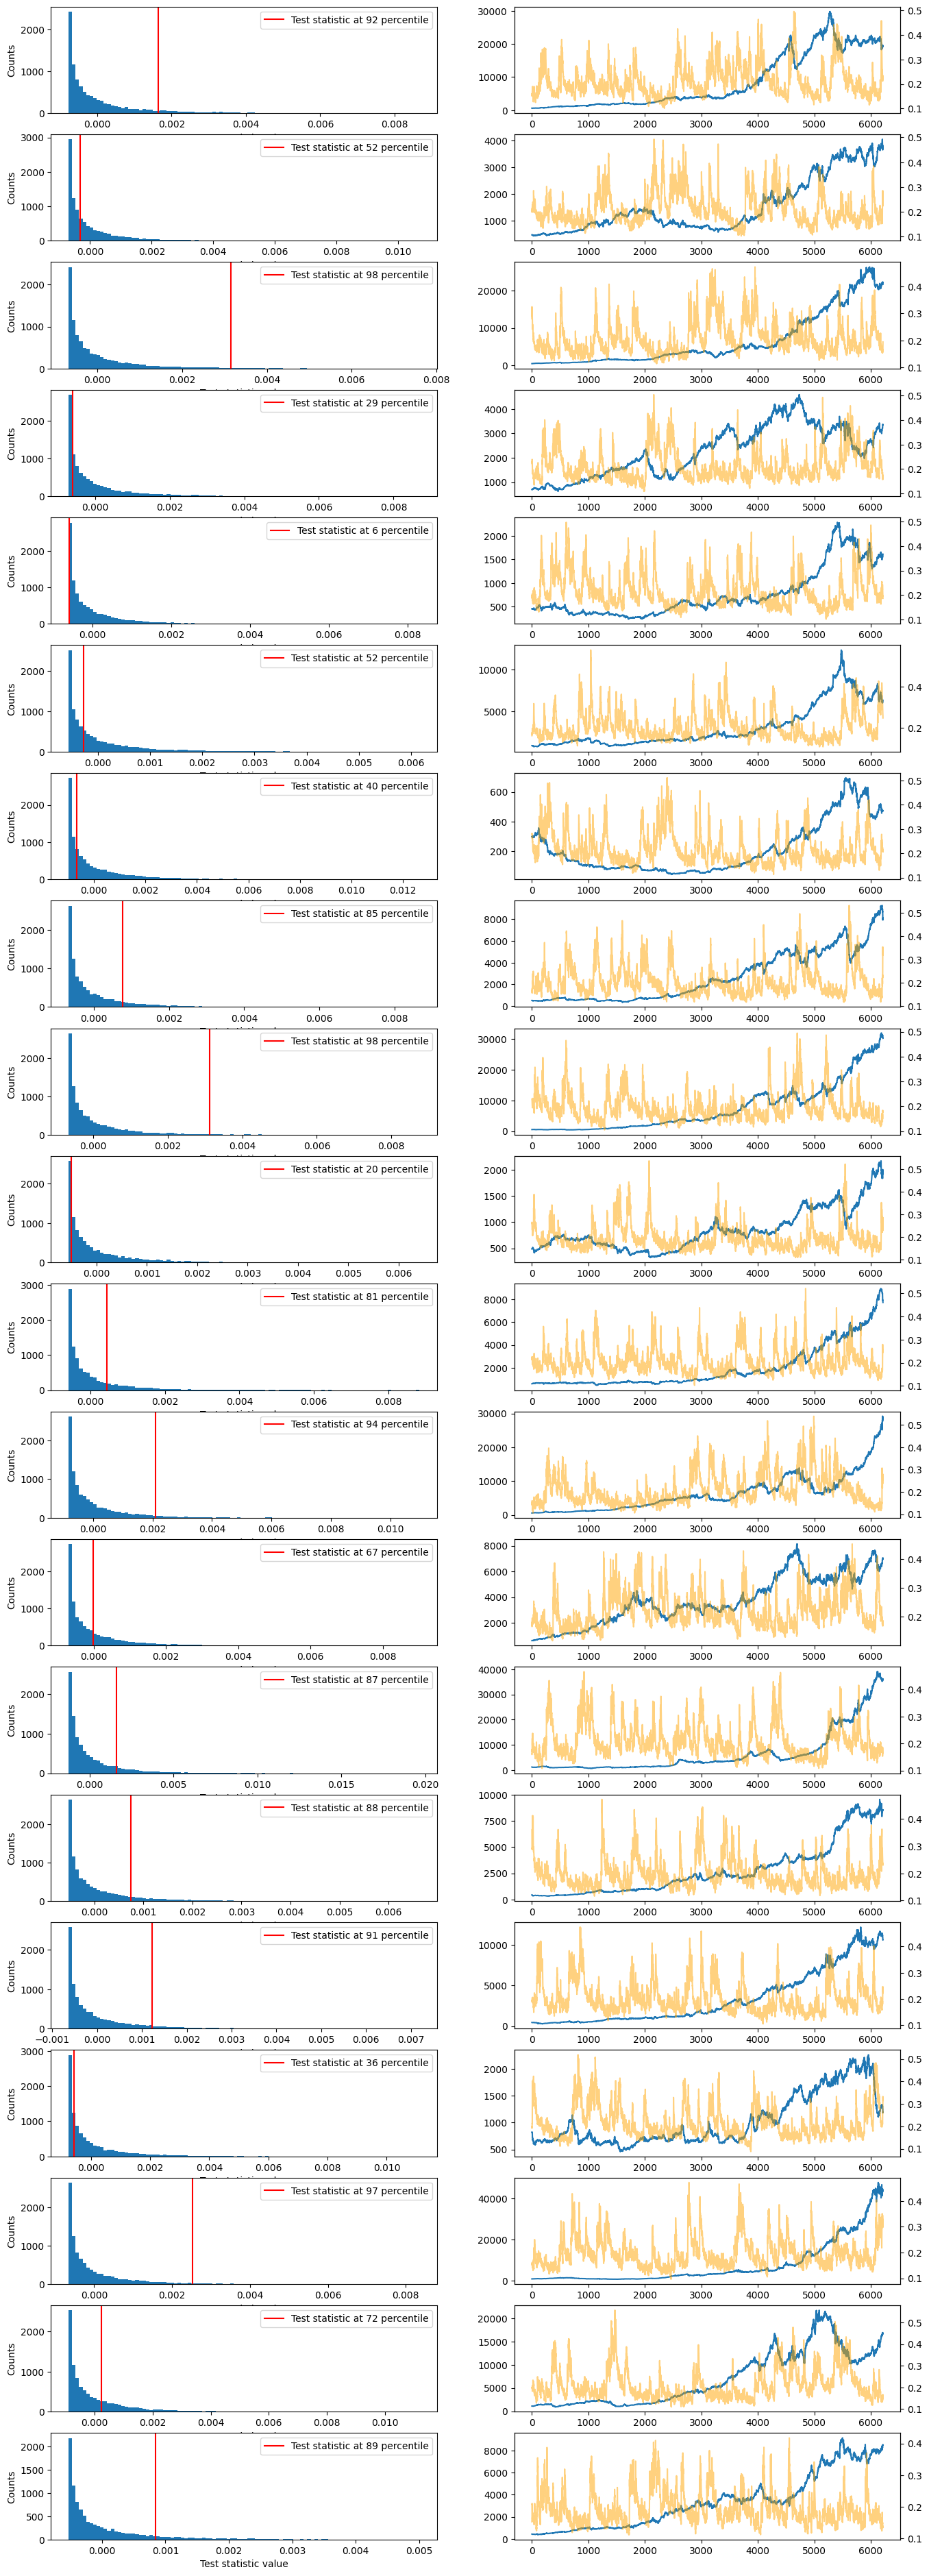

In [7]:
fig, ax = plt.subplots(figsize=(16,48), nrows=n_filter_samples, ncols=2)
for i in range(n_filter_samples):
    mmd_XY, null_mmd = ksig.tests.sig_kernel_test(X, Y[i], n_levels=n_levels, static_kernel=static_kernel,
                                                    num_permutations=num_permutations, ratio_plot=False, stats_plot=False)

    # calculate percentile of actual test statistic
    percentile = (null_mmd < mmd_XY).sum() / len(null_mmd)

    ax[i, 0].hist(null_mmd, bins=100)

    ax[i, 0].axvline(x=mmd_XY, c='r')
    legend = [f'Test statistic at {int(percentile*100)} percentile']

    ax[i, 0].legend(legend)
    ax[i, 0].set_xlabel('Test statistic value')
    ax[i, 0].set_ylabel('Counts')

    ax[i, 1].plot(samples[i,:,0], label='SPX')
    ax1 = ax[i, 1].twinx()
    ax1.plot(samples[i,:,1], label='VIX', alpha=0.5, c='orange')